/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_5972/1362368199.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['EXAMDT'] = pd.to_datetime(df['EXAMDT'], errors='coerce')


<Figure size 1000x600 with 0 Axes>

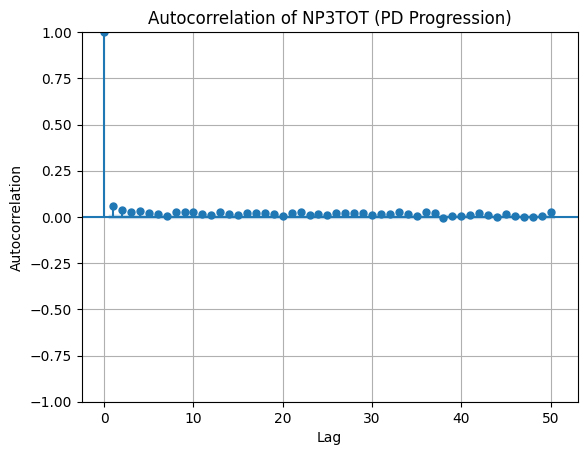

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

# Load your CSV
df = pd.read_csv('/Users/larsheijnen/Thesis/data/MDS-UPDRS_Part_III_21Mar2025.csv')

# Parse dates
df['EXAMDT'] = pd.to_datetime(df['EXAMDT'], errors='coerce')

# Filter out rows with missing dates or NP3TOT values
df = df.dropna(subset=['EXAMDT', 'NP3TOT'])

# Sort by date
df = df.sort_values('EXAMDT')

# Ensure NP3TOT is numeric
df['NP3TOT'] = pd.to_numeric(df['NP3TOT'], errors='coerce')

# Drop rows with missing NP3TOT values after conversion
df = df.dropna(subset=['NP3TOT'])

# Plot the autocorrelation of NP3TOT using statsmodels
plt.figure(figsize=(10, 6))
plot_acf(df['NP3TOT'], lags=50)  # Adjust the number of lags for better visualization
plt.title('Autocorrelation of NP3TOT (PD Progression)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid()
plt.show()

In [2]:
autocorr_values = acf(df['NP3TOT'], nlags=50)  # Adjust the number of lags as needed

# Print the autocorrelation values
for lag, value in enumerate(autocorr_values):
    print(f"Lag {lag}: {value:.3f}")

Lag 0: 1.000
Lag 1: 0.059
Lag 2: 0.040
Lag 3: 0.026
Lag 4: 0.030
Lag 5: 0.023
Lag 6: 0.016
Lag 7: 0.006
Lag 8: 0.028
Lag 9: 0.028
Lag 10: 0.025
Lag 11: 0.016
Lag 12: 0.012
Lag 13: 0.026
Lag 14: 0.018
Lag 15: 0.013
Lag 16: 0.019
Lag 17: 0.021
Lag 18: 0.022
Lag 19: 0.014
Lag 20: 0.007
Lag 21: 0.019
Lag 22: 0.026
Lag 23: 0.013
Lag 24: 0.015
Lag 25: 0.013
Lag 26: 0.021
Lag 27: 0.021
Lag 28: 0.021
Lag 29: 0.021
Lag 30: 0.012
Lag 31: 0.014
Lag 32: 0.016
Lag 33: 0.027
Lag 34: 0.013
Lag 35: 0.008
Lag 36: 0.024
Lag 37: 0.020
Lag 38: -0.005
Lag 39: 0.003
Lag 40: 0.006
Lag 41: 0.012
Lag 42: 0.019
Lag 43: 0.011
Lag 44: -0.001
Lag 45: 0.017
Lag 46: 0.006
Lag 47: -0.000
Lag 48: 0.002
Lag 49: 0.003
Lag 50: 0.024


/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_5972/422949123.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_resampled = df['NP3TOT'].resample('M').mean()


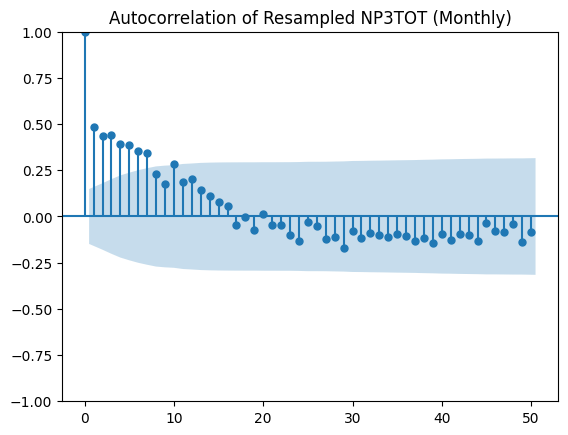

In [4]:
# Resample data to monthly intervals and take the mean of NP3TOT
df.set_index('EXAMDT', inplace=True)
df_resampled = df['NP3TOT'].resample('M').mean()

# Plot autocorrelation on resampled data
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_resampled.dropna(), lags=50)
plt.title('Autocorrelation of Resampled NP3TOT (Monthly)')
plt.show()